# Basic GAN 실습

In [1]:
#!pip install tqdm
#!conda install pytorch torchvision torchaudio cudatoolkit=11.1 -c pytorch

- [Generative Adversarial Networks](https://arxiv.org/abs/1406.2661)
- [NIPS 2016 Tutorial:
Generative Adversarial Networks](https://arxiv.org/pdf/1701.00160.pdf)
- [image source](https://xiaohongliu.ca/post/gan/)
![gan2-2.PNG](attachment:gan2-2.PNG)

## Library

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import numpy as np
import math
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets
from torchvision import models
from torchvision import transforms
from torch.utils.data import DataLoader

## Hyperparameters

In [4]:
"""
학습에 사용될 hyperparameter 값들을 넣을 class를 정의합니다.
"""
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

In [5]:
"""
GAN model 학습에 사용되는 결과 이미지 저장 경로, 에포크 수, 모델 입력 이미지 크기 등을 정의합니다.
"""
config = AttrDict()
config.data_path = 'data/'
config.save_path = 'save/'
config.dataset = 'CIFAR10' #CIFAR10
config.n_epoch = 500
config.log_interval = 100
config.save_interval = 20
config.batch_size = 64
config.learning_rate = 0.0002
config.b1 = 0.5
config.b2 = 0.999
config.img_shape = (3, 32, 32)
config.latent_size = 100
"""
모델 입력 이미지에 수행할 normalization과 모델 생성 결과 이미지에 수행할 denormalization을 정의합니다.
"""
config.augmentation = transforms.Compose([
                        transforms.Resize((config.img_shape[1], config.img_shape[2])),
                        transforms.ToTensor(),
                        transforms.Normalize(mean=[0.5], std=[0.5]) 
                      ])
config.denormalize = lambda x: x*0.5+0.5
config.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
if not os.path.isdir(config.data_path):
    os.makedirs(config.data_path)
if not os.path.isdir(os.path.join(config.save_path, config.dataset)):
    os.makedirs(os.path.join(config.save_path, config.dataset))

In [7]:
config.device

device(type='cpu')

In [8]:

#torch.cuda.current_device()
os.environ["CUDA_VISIBLE_DEVICES"]
#torch.cuda_path
torch.cuda.is_available()
#torch.cuda_version
#torch.cuda.get_device_name(1)

False

## Data load

In [9]:
"""
MNIST와 CIFAR-10은 torchvision 라이브러리에서 제공하여 아래와 같이 사용할 수 있습니다.
"""
if config.dataset == 'MNIST':
    train_dataset = datasets.MNIST(config.data_path,
                                    train=True,
                                    download=True,
                                    transform=config.augmentation
                                  ) 
elif config.dataset == 'CIFAR10': 
    train_dataset = datasets.CIFAR10(config.data_path,
                                       train=True,
                                       download=True,
                                       transform=config.augmentation
                                     )
"""
training set을 Dataloader에 넣습니다. 
"""
train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
print(train_dataset)

Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data/
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.5], std=[0.5])
           )


In [10]:
## GAN model
"""
 일반적으로, GAN에서는 loss가 Discriminator에서부터 Generator로 흐를 때 생길 수 있는 
 vanishing gradient 현상을 완화하기 위해 Leaky ReLU를 많이 사용합니다. 
"""
class Generator(nn.Module):
    def __init__(self, config):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            *self.block(config.latent_size, 128, batchnorm=False),
            *self.block(128, 256),
            *self.block(256, 512),
            *self.block(512, 1024),
            nn.Linear(1024, int(np.prod(config.img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.reshape(img.shape[0], *config.img_shape)
        return img
    
    def block(self, input_size, output_size, batchnorm=True):
        layers = [nn.Linear(input_size, output_size)]
        if batchnorm:
            layers.append(nn.BatchNorm1d(output_size))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        return layers

In [11]:
class Discriminator(nn.Module):
    def __init__(self, config):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(config.img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img = img.reshape(img.shape[0], -1)
        validity = self.model(img)
        return validity

#### Binary Cross Entropy loss between the target and the input probabilities

- [torch.nn.BCELoss](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html)

![bceloss.PNG](attachment:bceloss.PNG)

In [12]:
"""
binary cross entropy loss를 사용하여 adversarial loss를 구현합니다.
"""
criterion = nn.BCELoss()

"""
Generator와 Discriminator를 각각 정의하고, 상응하는 optimizer도 함께 정의합니다.
"""
generator = Generator(config).to(config.device)
discriminator = Discriminator(config).to(config.device)

optimizer_g = torch.optim.Adam(generator.parameters(), lr=config.learning_rate, betas=(config.b1, config.b2))
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=config.learning_rate, betas=(config.b1, config.b2))

In [13]:
generator.model

Sequential(
  (0): Linear(in_features=100, out_features=128, bias=True)
  (1): LeakyReLU(negative_slope=0.2, inplace=True)
  (2): Linear(in_features=128, out_features=256, bias=True)
  (3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): LeakyReLU(negative_slope=0.2, inplace=True)
  (5): Linear(in_features=256, out_features=512, bias=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): LeakyReLU(negative_slope=0.2, inplace=True)
  (8): Linear(in_features=512, out_features=1024, bias=True)
  (9): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): LeakyReLU(negative_slope=0.2, inplace=True)
  (11): Linear(in_features=1024, out_features=3072, bias=True)
  (12): Tanh()
)

In [14]:
discriminator.model

Sequential(
  (0): Linear(in_features=3072, out_features=512, bias=True)
  (1): LeakyReLU(negative_slope=0.2, inplace=True)
  (2): Linear(in_features=512, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.2, inplace=True)
  (4): Linear(in_features=256, out_features=1, bias=True)
  (5): Sigmoid()
)

## Training

In [15]:
"""
Generator와 Discriminator를 번갈아 학습합니다.
"""
g_loss_list = []
d_loss_list = []
for epoch in tqdm(range(config.n_epoch)):
    for i, (real_img, _) in enumerate(train_loader):
        
        real_img = real_img.to(config.device)

        """
        adversarial loss에 사용될 ground truth들입니다.
        Discriminator에게 있어 실제 이미지는 1, generator가 생성한 fake 이미지는 0을 label로 합니다.
        반대로 Generator는 자신이 생성한 fake 이미지의 label이 1이 되게 하여 Discriminator를 fooling 합니다.
        """
        valid_label = torch.ones((real_img.shape[0], 1), device=config.device, dtype=torch.float32)
        fake_label = torch.zeros((real_img.shape[0], 1), device=config.device, dtype=torch.float32)
        
        # ====================================================#
        #                Train Discriminator                  #
        # ====================================================#

        """
        Gaussian random noise를 Generator에게 입력하여 fake 이미지들을 생성합니다.
        """
        z = torch.randn((real_img.shape[0], config.latent_size), device=config.device, dtype=torch.float32)
        gen_img = generator(z)

        """
        Discriminator가 실제 이미지와 Generator가 생성한 이미지를 잘 구별하는지 loss를 계산합니다.
        이 때, Generator는 현재 계산된 loss로 학습되지 않으므로, 
        detach() 함수를 이용하여 생성 이미지를 computation graph에서 분리한 후 Discriminator의 입력으로 넣어줍니다. 
        """
        real_loss = criterion(discriminator(real_img), valid_label)
        fake_loss = criterion(discriminator(gen_img.detach()), fake_label)
        d_loss = (real_loss + fake_loss) * 0.5
        
        """
        Discriminator를 업데이트합니다.
        """
        optimizer_d.zero_grad()
        d_loss.backward()
        optimizer_d.step()

        # ====================================================#
        #                   Train Generator                   #
        # ====================================================#

        """
        Gaussian random noise를 Generator에게 입력하여 fake 이미지들을 생성합니다.
        """
        z = torch.randn((real_img.shape[0], config.latent_size), device=config.device, dtype=torch.float32)
        gen_img = generator(z)

        """
        Generator가 Discriminator를 속일 수 있는지 loss를 계산합니다.
        """
        g_loss = criterion(discriminator(gen_img), valid_label)
        
        """
        Generator를 업데이트합니다.
        """
        optimizer_g.zero_grad()
        g_loss.backward()
        optimizer_g.step()

        if (i+1) % config.log_interval == 0:
            g_loss_list.append(g_loss.item())
            d_loss_list.append(d_loss.item())
            print('Epoch [{}/{}] Batch [{}/{}] Discriminator loss: {:.4f} Generator loss: {:.4f}'.format(
                epoch+1, config.n_epoch, i+1, len(train_loader), d_loss.item(), g_loss.item()))

    if (epoch+1) % config.save_interval == 0:
        save_path = os.path.join(config.save_path, config.dataset, 'epoch_[{}].png'.format(epoch+1))
        gen_img = config.denormalize(gen_img)
        torchvision.utils.save_image(gen_img.data[:25], save_path, nrow=5, normalize=True)

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/500] Batch [100/782] Discriminator loss: 0.5566 Generator loss: 2.0546
Epoch [1/500] Batch [200/782] Discriminator loss: 0.5239 Generator loss: 1.8828
Epoch [1/500] Batch [300/782] Discriminator loss: 0.5901 Generator loss: 3.5278
Epoch [1/500] Batch [400/782] Discriminator loss: 0.6246 Generator loss: 1.7305
Epoch [1/500] Batch [500/782] Discriminator loss: 0.6203 Generator loss: 1.8179
Epoch [1/500] Batch [600/782] Discriminator loss: 0.4953 Generator loss: 1.7541
Epoch [1/500] Batch [700/782] Discriminator loss: 0.5203 Generator loss: 1.8410
Epoch [2/500] Batch [100/782] Discriminator loss: 0.5517 Generator loss: 1.4788
Epoch [2/500] Batch [200/782] Discriminator loss: 0.5170 Generator loss: 1.5574
Epoch [2/500] Batch [300/782] Discriminator loss: 0.5358 Generator loss: 1.6666
Epoch [2/500] Batch [400/782] Discriminator loss: 0.5571 Generator loss: 1.4617
Epoch [2/500] Batch [500/782] Discriminator loss: 0.5221 Generator loss: 1.3792
Epoch [2/500] Batch [600/782] Discrimina

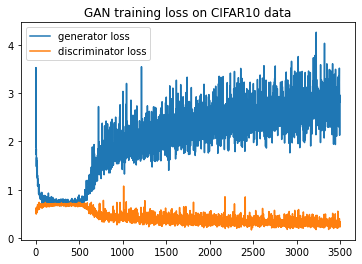

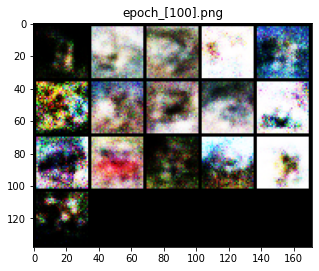

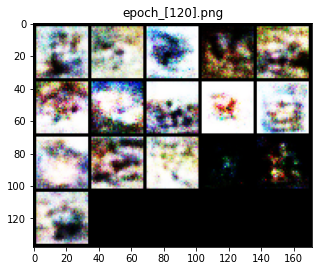

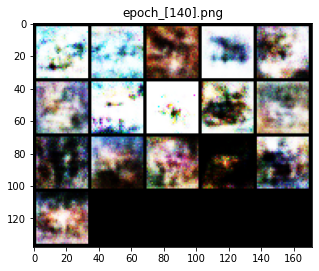

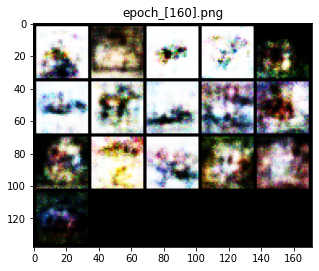

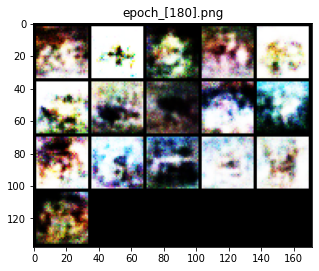

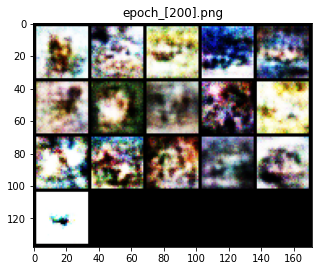

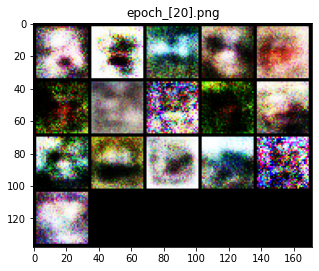

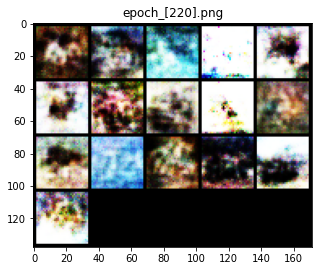

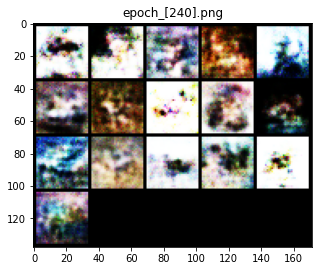

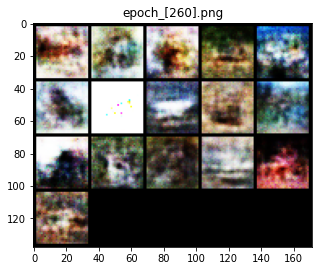

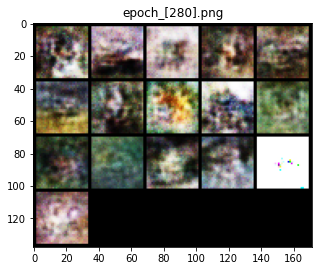

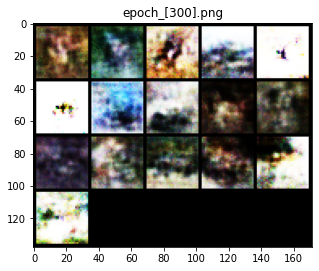

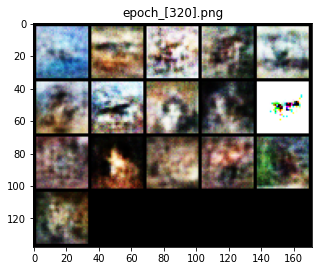

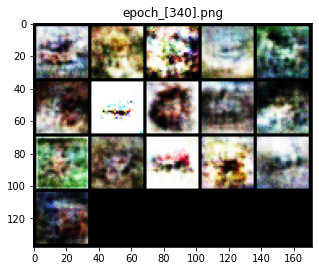

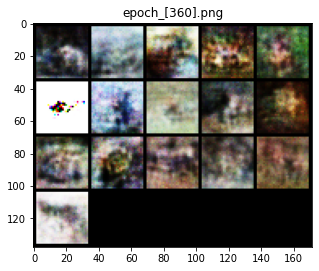

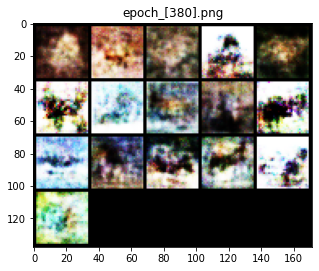

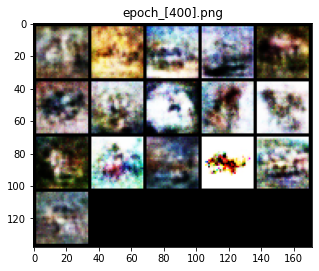

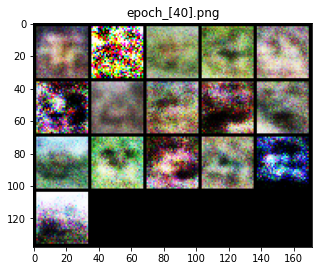

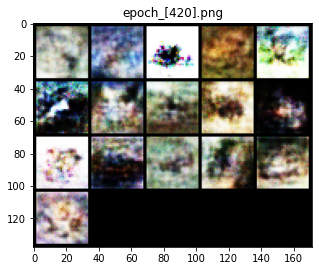

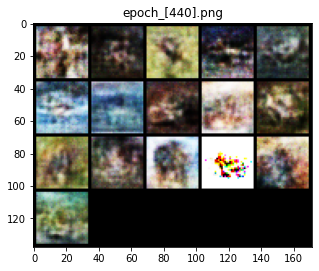

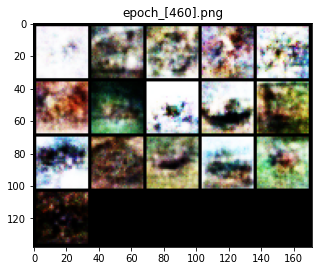

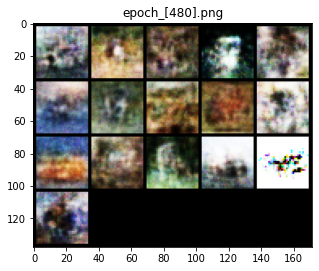

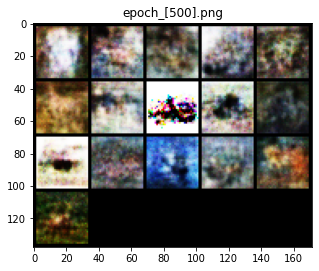

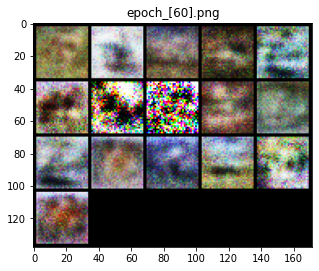

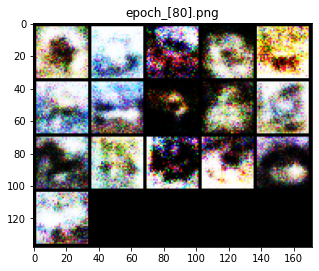

In [16]:
plt.title('GAN training loss on {} data'.format(config.dataset))
plt.plot(g_loss_list, label='generator loss')
plt.plot(d_loss_list, label='discriminator loss')
plt.legend()
plt.show()
## Qualitative results
save_path = os.path.join(config.save_path, config.dataset)
for image_path in os.listdir(save_path):
    if image_path.endswith('.png'):
        plt.figure(figsize=(5,5))
        image = Image.open(os.path.join(save_path, image_path))
        plt.title(image_path)
        plt.imshow(image)
        plt.show()
